<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session7/EVA7_Assignment7_AdvancedConcepts_AbhinavP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA7 - Assignment 7 - Advanced Concepts

Submission by Abhinav Pujahari (abhinavpujahari@gmail.com), Satwik Mishra (satwiksmishra@gmail.com), Yuvaraj V (yuvaraj100493@gmail.com) - Group 9

## Goals
1. Create a classification NN to train the CIFAR10 dataset to beyond 87% accuracy.
2. Network must have less than 100k parameters
3. One of the layers must use dilated convolution
4. 2 of the layers must use depthwise separable convolution
5. GAP must be used and mapped to the number of classes
6. Use Albumentation library to apply transformations
7. Code must be modular

## Import Dependencies

In [1]:
!pip install albumentations==0.4.6
!pip install torchsummary

In [2]:
import torch
import torchvision
import data_handling as d
import model_updated as m
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR, CosineAnnealingLR
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## GPU Check

In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


CUDA Available? True


## Data Download, Transformations & Dataset Creation

In [4]:
## Get Dataset Statistics
mean, std = d.return_dataset_statistics()

## Define data transformations
train_transforms, test_transforms = d.albumentation_augmentation(mean, std)

## Download & return transformed datasets
trainset, testset = d.return_datasets(train_transforms, test_transforms)

## Define data loaders
trainloader, testloader = d.return_dataloaders(trainset, testset, cuda)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualize Data Examples

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship  bird   cat   dog  bird truck truck plane plane  ship truck  frog  bird  bird   dog  frog


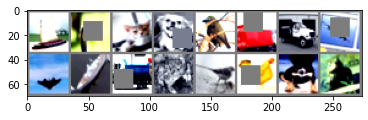

In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## Model Summary

In [6]:
from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = m.Net(0.01).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 30, 30]             324
              ReLU-2           [-1, 12, 30, 30]               0
       BatchNorm2d-3           [-1, 12, 30, 30]              24
           Dropout-4           [-1, 12, 30, 30]               0
            Conv2d-5           [-1, 24, 28, 28]           2,592
              ReLU-6           [-1, 24, 28, 28]               0
       BatchNorm2d-7           [-1, 24, 28, 28]              48
           Dropout-8           [-1, 24, 28, 28]               0
            Conv2d-9           [-1, 48, 14, 14]          10,368
             ReLU-10           [-1, 48, 14, 14]               0
      BatchNorm2d-11           [-1, 48, 14, 14]              96
          Dropout-12           [-1, 48, 14, 14]               0
           Conv2d-13           [-1, 48, 14, 14]          20,736
             ReLU-14           [-1

## Model Training

In [7]:
import train, test
train_acc, train_losses, test_acc, test_losses, lrs = [], [], [], [], []

## Define Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)

## Define Scheduler
scheduler = OneCycleLR(optimizer, max_lr = 0.015, epochs = 100, steps_per_epoch = len(trainloader))

## Define loss function
criterion = nn.CrossEntropyLoss()

## Define number of epochs and begin training
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train.train(model, device, trainloader, train_acc, train_losses, optimizer, scheduler, criterion, lrs)
    test.test(model, device, testloader, test_acc, test_losses, criterion)


EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.4182028770446777 Batch_id=390 LR=0.00064 Accuracy=41.16: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 0.0105, Accuracy: 5630/10000 (56.30%)

EPOCH: 2


Loss=1.3627511262893677 Batch_id=390 LR=0.00076 Accuracy=53.41: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]



Test set: Average loss: 0.0089, Accuracy: 6234/10000 (62.34%)

EPOCH: 3


Loss=1.152390718460083 Batch_id=390 LR=0.00095 Accuracy=58.37: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]



Test set: Average loss: 0.0077, Accuracy: 6747/10000 (67.47%)

EPOCH: 4


Loss=1.213974952697754 Batch_id=390 LR=0.00122 Accuracy=62.20: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s]



Test set: Average loss: 0.0071, Accuracy: 6897/10000 (68.97%)

EPOCH: 5


Loss=1.1030436754226685 Batch_id=390 LR=0.00156 Accuracy=64.54: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.0066, Accuracy: 7159/10000 (71.59%)

EPOCH: 6


Loss=1.0618053674697876 Batch_id=390 LR=0.00198 Accuracy=65.91: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 0.0065, Accuracy: 7202/10000 (72.02%)

EPOCH: 7


Loss=0.797615110874176 Batch_id=390 LR=0.00245 Accuracy=67.04: 100%|██████████| 391/391 [00:18<00:00, 21.18it/s]



Test set: Average loss: 0.0061, Accuracy: 7304/10000 (73.04%)

EPOCH: 8


Loss=0.8085732460021973 Batch_id=390 LR=0.00298 Accuracy=67.99: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]



Test set: Average loss: 0.0059, Accuracy: 7467/10000 (74.67%)

EPOCH: 9


Loss=0.8079002499580383 Batch_id=390 LR=0.00357 Accuracy=68.96: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]



Test set: Average loss: 0.0055, Accuracy: 7572/10000 (75.72%)

EPOCH: 10


Loss=0.9403778314590454 Batch_id=390 LR=0.00420 Accuracy=69.70: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]



Test set: Average loss: 0.0053, Accuracy: 7717/10000 (77.17%)

EPOCH: 11


Loss=0.874447226524353 Batch_id=390 LR=0.00487 Accuracy=70.28: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.0052, Accuracy: 7754/10000 (77.54%)

EPOCH: 12


Loss=0.6974995732307434 Batch_id=390 LR=0.00558 Accuracy=70.86: 100%|██████████| 391/391 [00:18<00:00, 21.25it/s]



Test set: Average loss: 0.0052, Accuracy: 7716/10000 (77.16%)

EPOCH: 13


Loss=0.5785588026046753 Batch_id=390 LR=0.00630 Accuracy=71.72: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 0.0050, Accuracy: 7831/10000 (78.31%)

EPOCH: 14


Loss=0.8364232778549194 Batch_id=390 LR=0.00705 Accuracy=71.69: 100%|██████████| 391/391 [00:18<00:00, 20.78it/s]



Test set: Average loss: 0.0050, Accuracy: 7814/10000 (78.14%)

EPOCH: 15


Loss=0.9049538373947144 Batch_id=390 LR=0.00780 Accuracy=71.97: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]



Test set: Average loss: 0.0052, Accuracy: 7764/10000 (77.64%)

EPOCH: 16


Loss=0.822877049446106 Batch_id=390 LR=0.00855 Accuracy=71.93: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.0055, Accuracy: 7745/10000 (77.45%)

EPOCH: 17


Loss=0.8137837648391724 Batch_id=390 LR=0.00930 Accuracy=72.68: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 0.0049, Accuracy: 7877/10000 (78.77%)

EPOCH: 18


Loss=0.904919445514679 Batch_id=390 LR=0.01003 Accuracy=72.70: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 0.0050, Accuracy: 7843/10000 (78.43%)

EPOCH: 19


Loss=0.7099722623825073 Batch_id=390 LR=0.01073 Accuracy=73.26: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 0.0048, Accuracy: 7924/10000 (79.24%)

EPOCH: 20


Loss=0.8907170295715332 Batch_id=390 LR=0.01140 Accuracy=73.65: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]



Test set: Average loss: 0.0045, Accuracy: 8025/10000 (80.25%)

EPOCH: 21


Loss=0.5598000288009644 Batch_id=390 LR=0.01203 Accuracy=73.77: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.0046, Accuracy: 8013/10000 (80.13%)

EPOCH: 22


Loss=0.5517024397850037 Batch_id=390 LR=0.01262 Accuracy=74.03: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 0.0046, Accuracy: 7953/10000 (79.53%)

EPOCH: 23


Loss=0.763256847858429 Batch_id=390 LR=0.01315 Accuracy=73.96: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]



Test set: Average loss: 0.0052, Accuracy: 7759/10000 (77.59%)

EPOCH: 24


Loss=1.097031831741333 Batch_id=390 LR=0.01363 Accuracy=74.23: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s]



Test set: Average loss: 0.0047, Accuracy: 7990/10000 (79.90%)

EPOCH: 25


Loss=0.8790682554244995 Batch_id=390 LR=0.01404 Accuracy=74.31: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]



Test set: Average loss: 0.0046, Accuracy: 7947/10000 (79.47%)

EPOCH: 26


Loss=0.7003430128097534 Batch_id=390 LR=0.01438 Accuracy=74.58: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s]



Test set: Average loss: 0.0046, Accuracy: 7968/10000 (79.68%)

EPOCH: 27


Loss=0.8674032092094421 Batch_id=390 LR=0.01465 Accuracy=74.59: 100%|██████████| 391/391 [00:19<00:00, 20.51it/s]



Test set: Average loss: 0.0058, Accuracy: 7584/10000 (75.84%)

EPOCH: 28


Loss=0.7169802188873291 Batch_id=390 LR=0.01484 Accuracy=74.54: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]



Test set: Average loss: 0.0049, Accuracy: 7866/10000 (78.66%)

EPOCH: 29


Loss=0.8821350932121277 Batch_id=390 LR=0.01496 Accuracy=74.59: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]



Test set: Average loss: 0.0044, Accuracy: 8127/10000 (81.27%)

EPOCH: 30


Loss=0.8554115295410156 Batch_id=390 LR=0.01500 Accuracy=74.86: 100%|██████████| 391/391 [00:19<00:00, 20.51it/s]



Test set: Average loss: 0.0049, Accuracy: 7973/10000 (79.73%)

EPOCH: 31


Loss=0.4741392135620117 Batch_id=390 LR=0.01499 Accuracy=75.11: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]



Test set: Average loss: 0.0051, Accuracy: 7861/10000 (78.61%)

EPOCH: 32


Loss=0.4994463324546814 Batch_id=390 LR=0.01497 Accuracy=75.10: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]



Test set: Average loss: 0.0048, Accuracy: 7977/10000 (79.77%)

EPOCH: 33


Loss=0.8382588624954224 Batch_id=390 LR=0.01493 Accuracy=75.23: 100%|██████████| 391/391 [00:18<00:00, 20.67it/s]



Test set: Average loss: 0.0043, Accuracy: 8171/10000 (81.71%)

EPOCH: 34


Loss=0.6247750520706177 Batch_id=390 LR=0.01488 Accuracy=75.50: 100%|██████████| 391/391 [00:18<00:00, 20.78it/s]



Test set: Average loss: 0.0043, Accuracy: 8139/10000 (81.39%)

EPOCH: 35


Loss=0.5975393056869507 Batch_id=390 LR=0.01481 Accuracy=75.24: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]



Test set: Average loss: 0.0042, Accuracy: 8159/10000 (81.59%)

EPOCH: 36


Loss=0.7857702374458313 Batch_id=390 LR=0.01473 Accuracy=76.13: 100%|██████████| 391/391 [00:18<00:00, 20.64it/s]



Test set: Average loss: 0.0045, Accuracy: 8020/10000 (80.20%)

EPOCH: 37


Loss=0.5822762250900269 Batch_id=390 LR=0.01463 Accuracy=75.87: 100%|██████████| 391/391 [00:19<00:00, 20.58it/s]



Test set: Average loss: 0.0045, Accuracy: 8093/10000 (80.93%)

EPOCH: 38


Loss=0.6329234838485718 Batch_id=390 LR=0.01452 Accuracy=75.95: 100%|██████████| 391/391 [00:18<00:00, 20.65it/s]



Test set: Average loss: 0.0044, Accuracy: 8106/10000 (81.06%)

EPOCH: 39


Loss=0.7999602556228638 Batch_id=390 LR=0.01440 Accuracy=76.41: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.0045, Accuracy: 8080/10000 (80.80%)

EPOCH: 40


Loss=0.6146901845932007 Batch_id=390 LR=0.01426 Accuracy=76.03: 100%|██████████| 391/391 [00:18<00:00, 20.58it/s]



Test set: Average loss: 0.0044, Accuracy: 8149/10000 (81.49%)

EPOCH: 41


Loss=0.7261620759963989 Batch_id=390 LR=0.01410 Accuracy=76.63: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]



Test set: Average loss: 0.0046, Accuracy: 8024/10000 (80.24%)

EPOCH: 42


Loss=0.7419472336769104 Batch_id=390 LR=0.01394 Accuracy=76.50: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0043, Accuracy: 8144/10000 (81.44%)

EPOCH: 43


Loss=0.8508678674697876 Batch_id=390 LR=0.01376 Accuracy=76.66: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0041, Accuracy: 8255/10000 (82.55%)

EPOCH: 44


Loss=0.6172779202461243 Batch_id=390 LR=0.01357 Accuracy=76.45: 100%|██████████| 391/391 [00:19<00:00, 20.34it/s]



Test set: Average loss: 0.0042, Accuracy: 8184/10000 (81.84%)

EPOCH: 45


Loss=0.6603461503982544 Batch_id=390 LR=0.01336 Accuracy=77.10: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]



Test set: Average loss: 0.0042, Accuracy: 8201/10000 (82.01%)

EPOCH: 46


Loss=0.5427733659744263 Batch_id=390 LR=0.01315 Accuracy=77.04: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0044, Accuracy: 8188/10000 (81.88%)

EPOCH: 47


Loss=0.6466785669326782 Batch_id=390 LR=0.01292 Accuracy=76.97: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]



Test set: Average loss: 0.0040, Accuracy: 8271/10000 (82.71%)

EPOCH: 48


Loss=0.6548808217048645 Batch_id=390 LR=0.01268 Accuracy=77.42: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]



Test set: Average loss: 0.0042, Accuracy: 8236/10000 (82.36%)

EPOCH: 49


Loss=0.48504143953323364 Batch_id=390 LR=0.01243 Accuracy=77.78: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 0.0040, Accuracy: 8319/10000 (83.19%)

EPOCH: 50


Loss=0.7430119514465332 Batch_id=390 LR=0.01218 Accuracy=77.64: 100%|██████████| 391/391 [00:19<00:00, 20.12it/s]



Test set: Average loss: 0.0040, Accuracy: 8355/10000 (83.55%)

EPOCH: 51


Loss=0.5220727324485779 Batch_id=390 LR=0.01191 Accuracy=77.87: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.0041, Accuracy: 8213/10000 (82.13%)

EPOCH: 52


Loss=0.6099251508712769 Batch_id=390 LR=0.01163 Accuracy=78.22: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]



Test set: Average loss: 0.0038, Accuracy: 8385/10000 (83.85%)

EPOCH: 53


Loss=0.7223024964332581 Batch_id=390 LR=0.01135 Accuracy=78.45: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]



Test set: Average loss: 0.0038, Accuracy: 8387/10000 (83.87%)

EPOCH: 54


Loss=0.5324755907058716 Batch_id=390 LR=0.01105 Accuracy=78.47: 100%|██████████| 391/391 [00:19<00:00, 20.12it/s]



Test set: Average loss: 0.0037, Accuracy: 8381/10000 (83.81%)

EPOCH: 55


Loss=0.7235103845596313 Batch_id=390 LR=0.01075 Accuracy=78.45: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]



Test set: Average loss: 0.0038, Accuracy: 8351/10000 (83.51%)

EPOCH: 56


Loss=0.46945175528526306 Batch_id=390 LR=0.01045 Accuracy=78.84: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]



Test set: Average loss: 0.0038, Accuracy: 8398/10000 (83.98%)

EPOCH: 57


Loss=0.46112877130508423 Batch_id=390 LR=0.01013 Accuracy=78.92: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0037, Accuracy: 8406/10000 (84.06%)

EPOCH: 58


Loss=0.5977641344070435 Batch_id=390 LR=0.00982 Accuracy=79.25: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]



Test set: Average loss: 0.0036, Accuracy: 8436/10000 (84.36%)

EPOCH: 59


Loss=0.7147887349128723 Batch_id=390 LR=0.00949 Accuracy=79.27: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0036, Accuracy: 8459/10000 (84.59%)

EPOCH: 60


Loss=0.534621000289917 Batch_id=390 LR=0.00917 Accuracy=79.28: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]



Test set: Average loss: 0.0036, Accuracy: 8464/10000 (84.64%)

EPOCH: 61


Loss=0.5327781438827515 Batch_id=390 LR=0.00884 Accuracy=79.83: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]



Test set: Average loss: 0.0035, Accuracy: 8536/10000 (85.36%)

EPOCH: 62


Loss=0.5779024958610535 Batch_id=390 LR=0.00851 Accuracy=79.73: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s]



Test set: Average loss: 0.0036, Accuracy: 8440/10000 (84.40%)

EPOCH: 63


Loss=0.597640872001648 Batch_id=390 LR=0.00817 Accuracy=80.11: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]



Test set: Average loss: 0.0036, Accuracy: 8453/10000 (84.53%)

EPOCH: 64


Loss=0.5819956064224243 Batch_id=390 LR=0.00784 Accuracy=80.31: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]



Test set: Average loss: 0.0037, Accuracy: 8452/10000 (84.52%)

EPOCH: 65


Loss=0.48704594373703003 Batch_id=390 LR=0.00750 Accuracy=80.65: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]



Test set: Average loss: 0.0035, Accuracy: 8510/10000 (85.10%)

EPOCH: 66


Loss=0.7173069715499878 Batch_id=390 LR=0.00716 Accuracy=80.44: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]



Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 67


Loss=0.5724495649337769 Batch_id=390 LR=0.00683 Accuracy=81.08: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s]



Test set: Average loss: 0.0034, Accuracy: 8567/10000 (85.67%)

EPOCH: 68


Loss=0.5310097336769104 Batch_id=390 LR=0.00649 Accuracy=80.85: 100%|██████████| 391/391 [00:19<00:00, 20.18it/s]



Test set: Average loss: 0.0035, Accuracy: 8496/10000 (84.96%)

EPOCH: 69


Loss=0.8328975439071655 Batch_id=390 LR=0.00616 Accuracy=81.26: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s]



Test set: Average loss: 0.0035, Accuracy: 8526/10000 (85.26%)

EPOCH: 70


Loss=0.38914984464645386 Batch_id=390 LR=0.00583 Accuracy=81.26: 100%|██████████| 391/391 [00:20<00:00, 19.53it/s]



Test set: Average loss: 0.0033, Accuracy: 8598/10000 (85.98%)

EPOCH: 71


Loss=0.4104253649711609 Batch_id=390 LR=0.00550 Accuracy=82.03: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]



Test set: Average loss: 0.0033, Accuracy: 8549/10000 (85.49%)

EPOCH: 72


Loss=0.40950292348861694 Batch_id=390 LR=0.00518 Accuracy=82.05: 100%|██████████| 391/391 [00:20<00:00, 19.40it/s]



Test set: Average loss: 0.0034, Accuracy: 8599/10000 (85.99%)

EPOCH: 73


Loss=0.6213899254798889 Batch_id=390 LR=0.00486 Accuracy=82.03: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]



Test set: Average loss: 0.0031, Accuracy: 8653/10000 (86.53%)

EPOCH: 74


Loss=0.7424572706222534 Batch_id=390 LR=0.00455 Accuracy=82.21: 100%|██████████| 391/391 [00:20<00:00, 19.38it/s]



Test set: Average loss: 0.0031, Accuracy: 8661/10000 (86.61%)

EPOCH: 75


Loss=0.3124796450138092 Batch_id=390 LR=0.00425 Accuracy=82.40: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]



Test set: Average loss: 0.0031, Accuracy: 8658/10000 (86.58%)

EPOCH: 76


Loss=0.4939703941345215 Batch_id=390 LR=0.00395 Accuracy=82.81: 100%|██████████| 391/391 [00:19<00:00, 19.87it/s]



Test set: Average loss: 0.0031, Accuracy: 8635/10000 (86.35%)

EPOCH: 77


Loss=0.3922973573207855 Batch_id=390 LR=0.00365 Accuracy=83.04: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]



Test set: Average loss: 0.0031, Accuracy: 8683/10000 (86.83%)

EPOCH: 78


Loss=0.2727883458137512 Batch_id=390 LR=0.00337 Accuracy=83.23: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s]



Test set: Average loss: 0.0031, Accuracy: 8703/10000 (87.03%)

EPOCH: 79


Loss=0.2711740732192993 Batch_id=390 LR=0.00309 Accuracy=83.38: 100%|██████████| 391/391 [00:20<00:00, 19.44it/s]



Test set: Average loss: 0.0030, Accuracy: 8739/10000 (87.39%)

EPOCH: 80


Loss=0.43906402587890625 Batch_id=390 LR=0.00282 Accuracy=83.47: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]



Test set: Average loss: 0.0030, Accuracy: 8742/10000 (87.42%)

EPOCH: 81


Loss=0.4002011716365814 Batch_id=390 LR=0.00256 Accuracy=83.74: 100%|██████████| 391/391 [00:20<00:00, 19.54it/s]



Test set: Average loss: 0.0030, Accuracy: 8729/10000 (87.29%)

EPOCH: 82


Loss=0.2774864137172699 Batch_id=390 LR=0.00232 Accuracy=84.17: 100%|██████████| 391/391 [00:20<00:00, 19.14it/s]



Test set: Average loss: 0.0029, Accuracy: 8772/10000 (87.72%)

EPOCH: 83


Loss=0.43204745650291443 Batch_id=390 LR=0.00208 Accuracy=84.49: 100%|██████████| 391/391 [00:20<00:00, 19.11it/s]



Test set: Average loss: 0.0029, Accuracy: 8762/10000 (87.62%)

EPOCH: 84


Loss=0.4332571029663086 Batch_id=390 LR=0.00185 Accuracy=84.37: 100%|██████████| 391/391 [00:20<00:00, 19.51it/s]



Test set: Average loss: 0.0029, Accuracy: 8754/10000 (87.54%)

EPOCH: 85


Loss=0.5857869386672974 Batch_id=390 LR=0.00164 Accuracy=84.89: 100%|██████████| 391/391 [00:20<00:00, 19.14it/s]



Test set: Average loss: 0.0029, Accuracy: 8745/10000 (87.45%)

EPOCH: 86


Loss=0.51007479429245 Batch_id=390 LR=0.00143 Accuracy=84.91: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]



Test set: Average loss: 0.0029, Accuracy: 8744/10000 (87.44%)

EPOCH: 87


Loss=0.45513319969177246 Batch_id=390 LR=0.00124 Accuracy=85.21: 100%|██████████| 391/391 [00:20<00:00, 19.43it/s]



Test set: Average loss: 0.0029, Accuracy: 8798/10000 (87.98%)

EPOCH: 88


Loss=0.5800142288208008 Batch_id=390 LR=0.00106 Accuracy=85.29: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]



Test set: Average loss: 0.0029, Accuracy: 8760/10000 (87.60%)

EPOCH: 89


Loss=0.39297395944595337 Batch_id=390 LR=0.00090 Accuracy=85.19: 100%|██████████| 391/391 [00:20<00:00, 19.43it/s]



Test set: Average loss: 0.0029, Accuracy: 8775/10000 (87.75%)

EPOCH: 90


Loss=0.41674891114234924 Batch_id=390 LR=0.00074 Accuracy=85.40: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s]



Test set: Average loss: 0.0029, Accuracy: 8787/10000 (87.87%)

EPOCH: 91


Loss=0.42338547110557556 Batch_id=390 LR=0.00060 Accuracy=85.85: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]



Test set: Average loss: 0.0029, Accuracy: 8808/10000 (88.08%)

EPOCH: 92


Loss=0.2976437509059906 Batch_id=390 LR=0.00048 Accuracy=85.75: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]



Test set: Average loss: 0.0028, Accuracy: 8811/10000 (88.11%)

EPOCH: 93


Loss=0.4407806396484375 Batch_id=390 LR=0.00037 Accuracy=85.90: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]



Test set: Average loss: 0.0028, Accuracy: 8821/10000 (88.21%)

EPOCH: 94


Loss=0.3534289598464966 Batch_id=390 LR=0.00027 Accuracy=86.08: 100%|██████████| 391/391 [00:20<00:00, 19.17it/s]



Test set: Average loss: 0.0028, Accuracy: 8790/10000 (87.90%)

EPOCH: 95


Loss=0.47051557898521423 Batch_id=390 LR=0.00019 Accuracy=86.17: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]



Test set: Average loss: 0.0028, Accuracy: 8799/10000 (87.99%)

EPOCH: 96


Loss=0.5748770833015442 Batch_id=390 LR=0.00012 Accuracy=86.16: 100%|██████████| 391/391 [00:21<00:00, 18.37it/s]



Test set: Average loss: 0.0028, Accuracy: 8795/10000 (87.95%)

EPOCH: 97


Loss=0.567805826663971 Batch_id=390 LR=0.00007 Accuracy=86.35: 100%|██████████| 391/391 [00:20<00:00, 18.80it/s]



Test set: Average loss: 0.0029, Accuracy: 8810/10000 (88.10%)

EPOCH: 98


Loss=0.42785120010375977 Batch_id=390 LR=0.00003 Accuracy=86.04: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s]



Test set: Average loss: 0.0028, Accuracy: 8817/10000 (88.17%)

EPOCH: 99


Loss=0.5853986740112305 Batch_id=390 LR=0.00001 Accuracy=86.18: 100%|██████████| 391/391 [00:20<00:00, 19.13it/s]



Test set: Average loss: 0.0028, Accuracy: 8816/10000 (88.16%)

EPOCH: 100


Loss=0.27428480982780457 Batch_id=390 LR=0.00000 Accuracy=86.23: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]



Test set: Average loss: 0.0028, Accuracy: 8808/10000 (88.08%)



## Plot Loss & Accuracy Graphs

Text(0.5, 1.0, 'Test Accuracy')

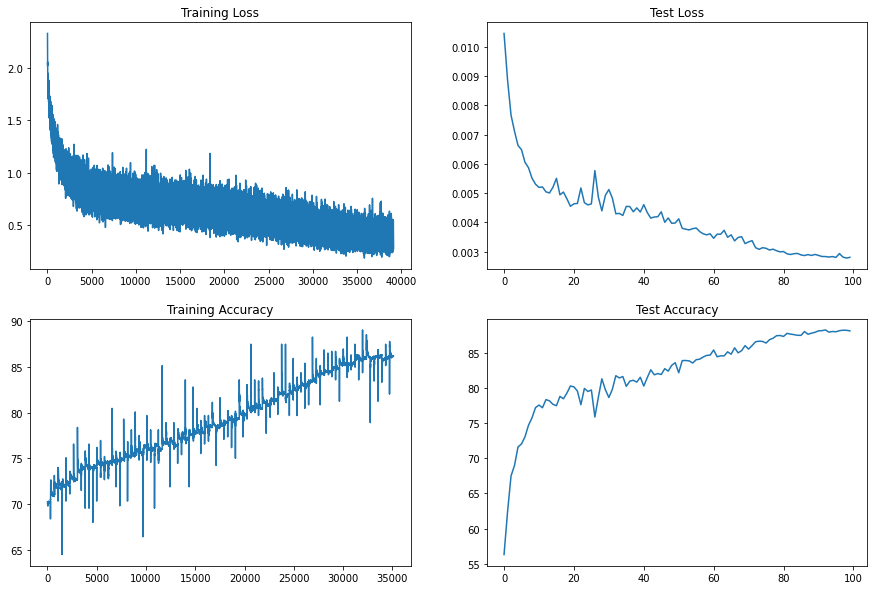

In [8]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Accuracy per class

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of plane : 83 %
Accuracy of   car : 100 %
Accuracy of  bird : 77 %
Accuracy of   cat : 63 %
Accuracy of  deer : 93 %
Accuracy of   dog : 87 %
Accuracy of  frog : 96 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %
